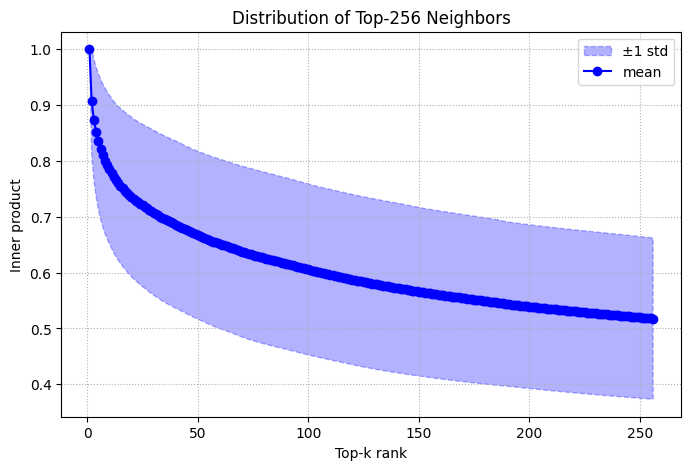

Finished processing pos_ratio=1.0, size=16384, vocab=65, topk=256


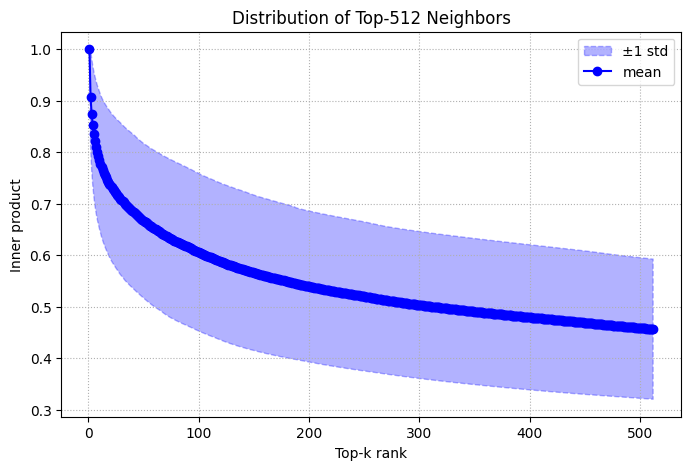

Finished processing pos_ratio=1.0, size=16384, vocab=65, topk=512


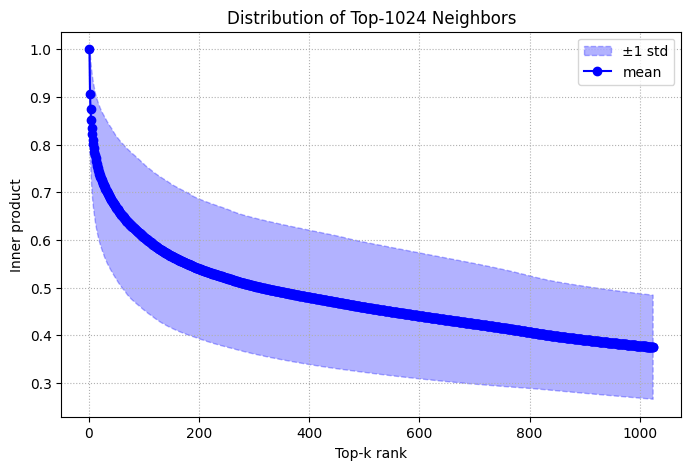

Finished processing pos_ratio=1.0, size=16384, vocab=65, topk=1024


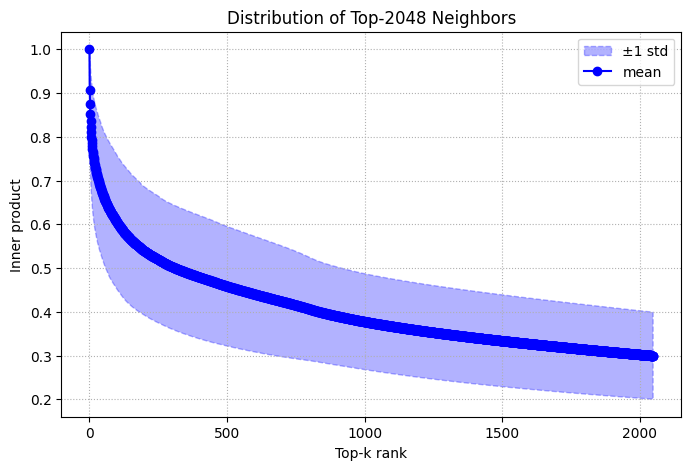

Finished processing pos_ratio=1.0, size=16384, vocab=65, topk=2048


In [3]:
import torch
from safetensors.torch import load_file, save_file
import matplotlib.pyplot as plt
import numpy as np


def topk_neighbors(embeddings: torch.Tensor, k: int = 256, block_size: int = 4096):
    """
    embeddings: (N, d) 已归一化
    k: 取最近的前 k 个（包含自身）
    block_size: 分块大小
    返回: (N, k) 内积值, (N, k) 索引
    """
    device = torch.device("cuda:0")
    embeddings = embeddings.to(device, non_blocking=True)
    N, d = embeddings.shape
    result_ids, result_vals = [], []

    for start in range(0, N, block_size):
        end = min(start + block_size, N)
        block = embeddings[start:end]  # (B, d)
        sim = block @ embeddings.T     # (B, N)
        vals, idx = torch.topk(sim, k, dim=1, largest=True, sorted=True)
        result_vals.append(vals)
        result_ids.append(idx)

    return torch.cat(result_vals, dim=0), torch.cat(result_ids, dim=0)


def plot_topk_distribution(topk_vals: torch.Tensor, k: int = 64):
    """
    topk_vals: (N, K) 内积值
    k: 可视化前 k 个
    绘制均值点和方差区域
    """
    vals_cpu = topk_vals[:, :k].detach().cpu().numpy()  # (N, k)
    mean_vals = vals_cpu.mean(axis=0)
    std_vals  = vals_cpu.std(axis=0)

    x = np.arange(1, k+1)

    plt.figure(figsize=(8, 5))
    # 方差带 (均值 ± std)
    plt.fill_between(x, mean_vals-std_vals, mean_vals+std_vals,
                     alpha=0.3, color='blue', linestyle='--', label='±1 std')
    # 均值点
    plt.plot(x, mean_vals, 'o-', color='blue', label='mean')
    plt.xlabel("Top-k rank")
    plt.ylabel("Inner product")
    plt.title(f"Distribution of Top-{k} Neighbors")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.show()


if __name__ == "__main__":
    best_valid_epochs = {
        65:  9999,
        384: 3000,
        512: 2000,
        768: 2000,
        1024: 2000
    }
    for N_vocab in [65]:
        for topk in [256, 512, 1024, 2048]:
            for pos_ratio in  [1.0]:
                for size in [16384]:
                # 1. 读取数据
                    path = f"voc{N_vocab}_normfixed20_b256_" + f"iters_{best_valid_epochs[N_vocab]}_" + f"ps{pos_ratio}_train{size}_cache_last.pth"
                    data = load_file(path)
                    emb = data['emb']   # (N, d)，已归一化

                    # 2. 计算 top-k
                    vals, ids = topk_neighbors(emb, k=topk)

                    # 3. 绘图
                    plot_topk_distribution(vals, k=topk)
                    
                    filted_data = {
                        "emb": data['emb'],
                        "y"  : data['y'],
                        "rk" : ids
                    }
                    
                    save_file(filted_data, f"rk{topk}_" + path)

                    print(f"Finished processing pos_ratio={pos_ratio}, size={size}, vocab={N_vocab}, topk={topk}")


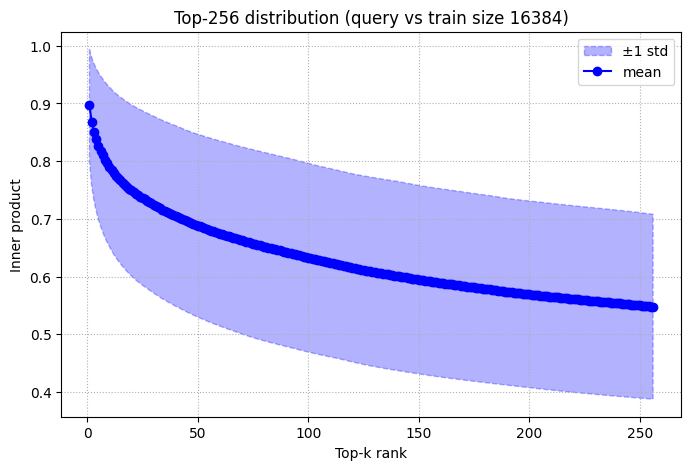

Finished processing pos_ratio=1.0, size=16384, topk=256, vocab=65


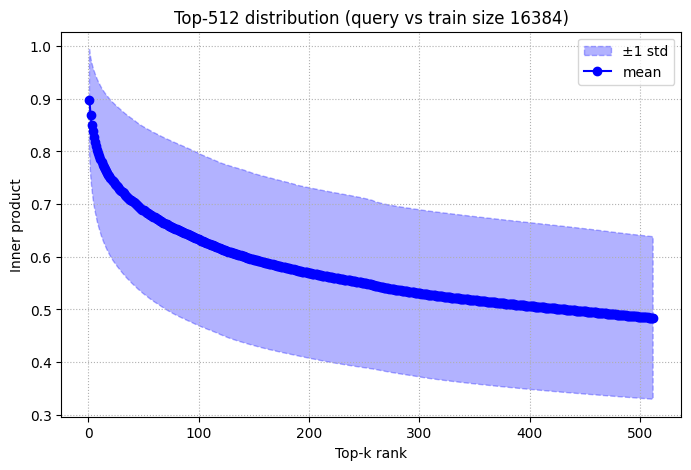

Finished processing pos_ratio=1.0, size=16384, topk=512, vocab=65


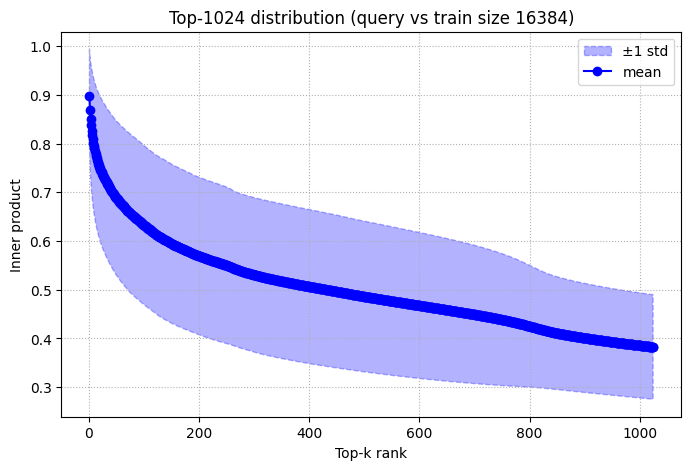

Finished processing pos_ratio=1.0, size=16384, topk=1024, vocab=65


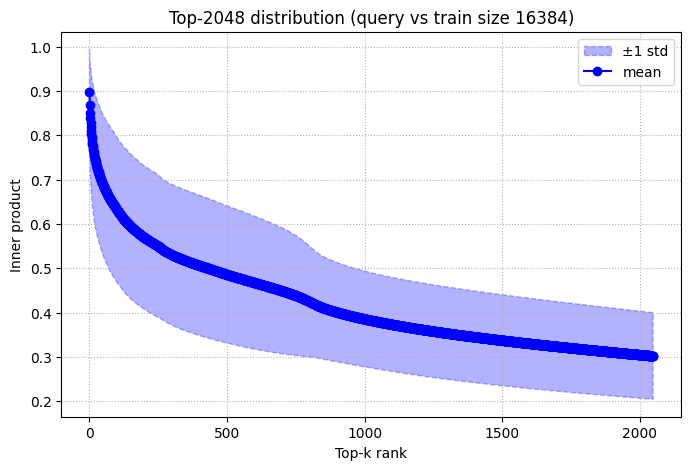

Finished processing pos_ratio=1.0, size=16384, topk=2048, vocab=65


In [4]:
# project_cross.py
import torch
from safetensors.torch import load_file, save_file
import matplotlib.pyplot as plt
import numpy as np


def topk_cross_neighbors(query: torch.Tensor, base: torch.Tensor, k: int = 256, block_size: int = 4096):
    """
    query: (Nq, d) 查询向量，已归一化
    base : (Nb, d) 检索库向量，已归一化
    k: top-k 数
    block_size: 分块大小
    返回: (Nq, k) 内积值, (Nq, k) 索引 (索引在 base 内部)
    """
    device = torch.device("cuda:0")
    query = query.to(device, non_blocking=True)
    base  = base.to(device, non_blocking=True)

    Nq, d = query.shape
    result_ids, result_vals = [], []

    for start in range(0, Nq, block_size):
        end = min(start + block_size, Nq)
        block = query[start:end]       # (B, d)
        sim = block @ base.T           # (B, Nb)
        vals, idx = torch.topk(sim, k, dim=1, largest=True, sorted=True)
        result_vals.append(vals)
        result_ids.append(idx)

    return torch.cat(result_vals, dim=0), torch.cat(result_ids, dim=0)


def plot_topk_distribution(topk_vals: torch.Tensor, k: int = 64, title: str = ""):
    vals_cpu = topk_vals[:, :k].detach().cpu().numpy()  # (N, k)
    mean_vals = vals_cpu.mean(axis=0)
    std_vals  = vals_cpu.std(axis=0)

    x = np.arange(1, k+1)

    plt.figure(figsize=(8, 5))
    plt.fill_between(x, mean_vals-std_vals, mean_vals+std_vals,
                     alpha=0.3, color='blue', linestyle='--', label='±1 std')
    plt.plot(x, mean_vals, 'o-', color='blue', label='mean')
    plt.xlabel("Top-k rank")
    plt.ylabel("Inner product")
    plt.title(title if title else f"Distribution of Top-{k} Neighbors")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.show()


if __name__ == "__main__":
    # 1. 读取另一个文件 (比如 valid/test)
    N_valid = 16384
    best_valid_epochs = {
        65 : 9999,
        384: 3000,
        512: 2000,
        768: 2000,
        1024: 2000
    }
    for N_vocab in [65]:
        for topk in [256, 512, 1024, 2048]:
            valid_path = f"voc{N_vocab}_normfixed20_b256_" + f"iters_{best_valid_epochs[N_vocab]}_" + f"valid{N_valid}_cache_last.pth"
            valid_data = load_file(valid_path)
            query_emb = valid_data['emb']
            query_y   = valid_data['y']

            # 2. 遍历 train 文件
            for pos_ratio in [1.0]:
                for size in [16384]:
                # 1. 读取数据
                    train_path = f"voc{N_vocab}_normfixed20_b256_" + f"iters_{best_valid_epochs[N_vocab]}_" + f"ps{pos_ratio}_train{size}_cache_last.pth"
                    train_data = load_file(train_path)
                    base_emb = train_data['emb']

                    # 3. 计算 cross top-k
                    vals, ids = topk_cross_neighbors(query_emb, base_emb, k=topk)

                    # 4. 绘图
                    plot_topk_distribution(vals, k=topk,
                                        title=f"Top-{topk} distribution (query vs train size {size})")
                    # 5. 保存结果
                    filtered_data = {
                        "emb": query_emb,
                        "y":   query_y,
                        "rk":  ids
                    }
                    save_file(filtered_data, f"rk{topk}_" + f"q=ps{pos_ratio}_train{size}_" + valid_path)

                    print(f"Finished processing pos_ratio={pos_ratio}, size={size}, topk={topk}, vocab={N_vocab}")

In [8]:
# project_cross.py
import torch
from safetensors.torch import load_file, save_file
import matplotlib.pyplot as plt
import numpy as np


def topk_cross_neighbors(query: torch.Tensor, base: torch.Tensor, k: int = 256, block_size: int = 4096):
    """
    query: (Nq, d) 查询向量，已归一化
    base : (Nb, d) 检索库向量，已归一化
    k: top-k 数
    block_size: 分块大小
    返回: (Nq, k) 内积值, (Nq, k) 索引 (索引在 base 内部)
    """
    device = torch.device("cpu")
    query = query.to(device, non_blocking=True)
    base  = base.to(device, non_blocking=True)

    Nq, d = query.shape
    result_ids, result_vals = [], []

    for start in range(0, Nq, block_size):
        end = min(start + block_size, Nq)
        block = query[start:end]       # (B, d)
        sim = block @ base.T           # (B, Nb)
        vals, idx = torch.topk(sim, k, dim=1, largest=True, sorted=True)
        result_vals.append(vals)
        result_ids.append(idx)

    return torch.cat(result_vals, dim=0), torch.cat(result_ids, dim=0)


def plot_topk_distribution(topk_vals: torch.Tensor, k: int = 64, title: str = ""):
    vals_cpu = topk_vals[:, :k].detach().cpu().numpy()  # (N, k)
    mean_vals = vals_cpu.mean(axis=0)
    std_vals  = vals_cpu.std(axis=0)

    x = np.arange(1, k+1)

    plt.figure(figsize=(8, 5))
    plt.fill_between(x, mean_vals-std_vals, mean_vals+std_vals,
                     alpha=0.3, color='blue', linestyle='--', label='±1 std')
    plt.plot(x, mean_vals, 'o-', color='blue', label='mean')
    plt.xlabel("Top-k rank")
    plt.ylabel("Inner product")
    plt.title(title if title else f"Distribution of Top-{k} Neighbors")
    plt.legend()
    plt.grid(True, linestyle=":")
    plt.show()

import torch.nn.functional as F

if __name__ == "__main__":
    # 1. 读取另一个文件 (比如 valid/test)
    best_valid_epochs = {
        384: 3000,
        512: 2000,
        768: 2000,
        1024: 2000
    }
    for N_vocab in [512]:
        topks = [1, 4, 8, 16, 32, 64, 256, 1024]
        gpt_ckpt = f"../ckpt/gpt/voc{N_vocab}_normfixed20_b256" + f"_iters_{best_valid_epochs[N_vocab]}.pth" # .format(2999)
        gpt_weights = torch.load(gpt_ckpt, map_location='cpu') # (N_vocab, n_embd), not pinned
        vocab_emb   = F.normalize(gpt_weights['token_embedding_table.weight'], dim=-1) # (N_valid, n_embd), not pinned
        
        for topk in topks:
            valid_path = f"voc{N_vocab}_normfixed20_b256_" + f"iters_{best_valid_epochs[N_vocab]}_" + f"valid2048_cache_last.pth"
            valid_data = load_file(valid_path, device='cpu')
            query_emb = valid_data['emb']
            query_y   = valid_data['y']

            
            
            # 2. 遍历 train 文件
            for pos_ratio in [0.875]:
                for size in [32768]:
                # 1. 读取数据
                    train_path = f"voc{N_vocab}_normfixed20_b256_" + f"iters_{best_valid_epochs[N_vocab]}_" + f"ps{pos_ratio}_train{size}_cache_last.pth"
                    train_data = load_file(train_path, device='cpu')
                    base_emb = train_data['emb']

                    # 3. 计算 cross top-k
                    vals, ids = topk_cross_neighbors(query_emb, base_emb, k=topk)

                    # === 3.5 追加：使用 topk 近邻的标签做众数投票，统计正确率 ===

                    train_y = train_data['y']                     # (N_train,)
                    neighbor_labels = train_y[ids]                # (N_valid, topk)

                    # 计算每行众数
                    # torch.mode 返回 (values, indices)
                    majority_labels, _ = torch.mode(neighbor_labels, dim=1)   # (N_valid,)

                    # 计算正确率
                    accuracy = (majority_labels == query_y).float().mean().item()

                    print(f"[Majority Vote Acc] pos_ratio={pos_ratio}, size={size}, topk={topk}, acc={accuracy:.4f}")
                    
                    # === 3.6 追加：teacher-eu-space 的预测 old_pred ===
                    # 使用与你 main_cte 完全一致的 teacher 逻辑
                    eu_logits = 20. * (query_emb @ vocab_emb.t())       # (N_valid, vocab_size)
                    old_pred = eu_logits.argmax(dim=-1)                  # (N_valid,)

                    # === 3.7 追加：now_pred = majority vote 结果 ===
                    now_pred = majority_labels                           # (N_valid,)

                    # === 3.8 统计 2×2 迁移矩阵 ===
                    full_targets = query_y                               # (N_valid,)

                    old_right = (old_pred == full_targets)
                    now_right = (now_pred == full_targets)

                    A = (( now_right &  old_right )).sum().item()        # 原来对 → 现在对
                    B = (( now_right & ~old_right )).sum().item()        # 原来错 → 现在对（好）
                    C = ((~now_right &  old_right )).sum().item()        # 原来对 → 现在错（坏）
                    D = ((~now_right & ~old_right )).sum().item()        # 原来错 → 现在错

                    N = full_targets.numel()

                    pctA = A / N * 100
                    pctB = B / N * 100
                    pctC = C / N * 100
                    pctD = D / N * 100

                    # === 3.9 输出两个独立的 2×2 表格 ===

                    print("\nTable 1: Prediction Transition (Count)")
                    print("+----------+--------------+--------------+")
                    print("|          | 原来对了     | 原来错了     |")
                    print("+----------+--------------+--------------+")
                    print(f"| 现在对了 | {A:10d}     | {B:10d}     |")
                    print("+----------+--------------+--------------+")
                    print(f"| 现在错了 | {C:10d}     | {D:10d}     |")
                    print("+----------+--------------+--------------+")
                    print("")

                    print("Table 2: Prediction Transition (Percentage)")
                    print("+----------+------------------+------------------+")
                    print("|          | 原来对了         | 原来错了         |")
                    print("+----------+------------------+------------------+")
                    print(f"| 现在对了 | {pctA:6.2f}%         | {pctB:6.2f}%         |")
                    print("+----------+------------------+------------------+")
                    print(f"| 现在错了 | {pctC:6.2f}%         | {pctD:6.2f}%         |")
                    print("+----------+------------------+------------------+")
                    print("")


/tmp/ipykernel_3442992/4181134618.py:65: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gpt_weights = torch.load(gpt_ckpt, map_location='cpu') # (N_vocab, n_embd), not pinned

[Majority Vote Acc] pos_ratio=0.875, size=32768, topk=1, acc=0.3433

Table 1: Prediction Transition (Count)
+----------+--------------+--------------+
|          | 原来对了     | 原来错了     |
+----------+--------------+--------------+
| 现在对了 |        635     |         68     |
+----------+--------------+--------------+
| 现在错了 |        173     |       1172     |
+----------+--------------+--------------+

Table 2: Prediction Transition (Percentage)
+----------+------------------+------------------+
|          | 原来对了         | 原来错了         |
+----------+------------------+------------------+
| 现在对了 |  31.01%         |   3.32%         |
+----------+------------------+------------------+
| 现在错了 |   8.45%         |  57.23%         |
+----------+------------------+------------------+

[Majority Vote Acc] pos_ratio=0.875, size=32768, topk=4, acc=0.3521

Table 1: Prediction Transition (Count)
+----------+--------------+--------------+
|          | 原来对了     | 原来错了     |
+----------+--------------+---